In [1]:
from common import *
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import logging, time
from sklearn.model_selection import train_test_split
import data_flow
import train

In [2]:
fnames = glob('../data/corpus/**.txt')

# Prepare data

In [8]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [23]:
docs = []
ids = []
for fn in tqdm_notebook(fnames[:]):
    with open(fn, 'rb') as f:
        ixs = [int(_ix) for _ix in f.read().split()]
    if len(ixs) == 0:
        print(fn)
        continue
    doc_vec = word_embeddings[ixs].mean(axis=0)
    docs.append(doc_vec)
    ids.append(basename(fn).split('.')[0])

../data/corpus/5984b653b6b11311aa638537.txt
../data/corpus/5984b69db6b1131591638547.txt
../data/corpus/5984b6fdb6b1131ae26384f4.txt
../data/corpus/5984b667b6b11313926384f7.txt
../data/corpus/5984b690b6b113159263850f.txt
../data/corpus/5984b65db6b1131294638541.txt
../data/corpus/5984b6bab6b11317b963851c.txt
../data/corpus/5984b592b6b113049f638531.txt
../data/corpus/5984b6bab6b11317a16384fd.txt
../data/corpus/5984b6a3b6b11316a563850e.txt
../data/corpus/5984b589b6b11304986384fd.txt
../data/corpus/5984b6c1b6b11317b0638527.txt
../data/corpus/5984b6bbb6b11317a163852f.txt
../data/corpus/5984b6bbb6b11317a1638546.txt
../data/corpus/5984b58fb6b1130489638517.txt
../data/corpus/5984b68fb6b11315926384f3.txt
../data/corpus/5984b68fb6b1131592638508.txt
../data/corpus/5984b58fb6b11304a963852e.txt
../data/corpus/5984b6bbb6b11317a1638536.txt
../data/corpus/5984b6a4b6b113169a638532.txt
../data/corpus/5984b6bab6b11317a163850f.txt
../data/corpus/5984b6c2b6b11317b8638545.txt
../data/corpus/5984b6c1b6b11317b

In [24]:
np.save('../data/avged_docs.npy', docs)
np.save('../data/avged_ids.npy', ids)

# Load data

In [3]:
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [4]:
docs = np.load('../data/avged_docs.npy')
ids = np.load('../data/avged_ids.npy')
docs = pd.DataFrame(docs, index=ids)
docs.sort_index(inplace=True)

# try unsupervised

In [42]:
val_vecs = []
for _id in tqdm_notebook(gold.keys()):
    ix = np.where(ids == _id)[0][0]
    val_vecs.append(docs[ix])

In [46]:
sim_mat = cosine_similarity(val_vecs, docs)

In [52]:
best = {}
for i, vec in enumerate(tqdm(sim_mat)):
    val_name = gold.keys()[i]
    train_ixs = vec.argsort()[-200:][::-1]
    top_train = [ids[i] for i in train_ixs]
    best[val_name] = top_train

100%|██████████| 184/184 [00:28<00:00,  6.53it/s]


100%|██████████| 184/184 [00:00<00:00, 16783.78it/s]


median
acc10     0.0
acc20     0.0
acc200    0.5
dtype: float64
mean
acc10     0.273007
acc20     0.355435
acc200    0.535145
dtype: float64


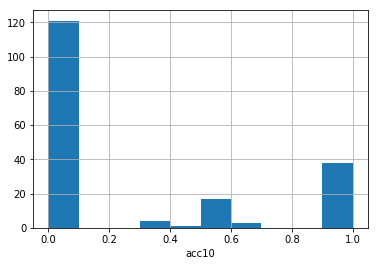

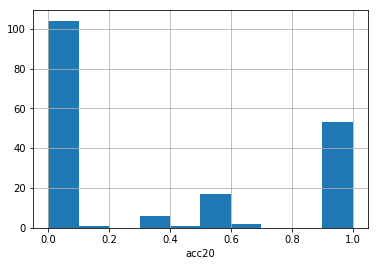

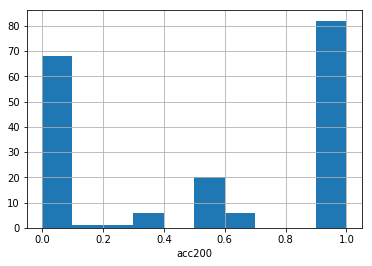

In [57]:
result = evaluate(best, gold)

ax = result['acc10'].hist()
ax.set_xlabel("acc10")
plt.show()

ax = result['acc20'].hist()
ax.set_xlabel("acc20")
plt.show()

ax = result['acc200'].hist()
ax.set_xlabel("acc200")
plt.show()

# try supervised

In [5]:
triples_all = list(data_flow.random_triples(sims, fnames, num_epochs=1, with_path=False, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)

100%|██████████| 368458/368458 [00:04<00:00, 84397.30it/s] 


# No batch normalization

In [51]:
embedding_size = 300
batch_size = 64
learning_rate = 0.001
sizes=[300, 200]

In [73]:
reload(train)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')

        model = train.FCNN(batch_size, sizes=sizes, 
                        learning_rate=learning_rate,
                        batch_norm=False)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary('train')
#         model.init_summary('val')

        tr_batch = data_flow.gen_batches(docs, triples_train[:1000*batch_size], batch_size)
#         val_batch = data_flow.gen_batches(docs, triples_val, 64)

        for step, X_train in enumerate(tr_batch):
            _, loss, summary, _embeds = sess.run([
                train_op, model.loss_op,
                model.merged_summary_op, model.doc_embed_normalized
            ], feed_dict = {model.phase: 1, X: X_train})
            model.add_summary(summary, step)
            logging.info('step %s, loss %s' % (step, loss))
            
#             if (step + 1) %  50 == 0:
#                 X_val = next(val_batch)
#                 [val_loss] = sess.run([loss], 
#                               feed_dict={'X:0': X_val,
#                                          'phase:0': 0})
#             if (step + 1) %  50 == 0:
#                 [test_loss, t20, t200] = sess.run([loss, top20, top200], 
#                              feed_dict={'X:0': X_test,
#                                         'phase:0': 0})
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
#     send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-25 21:02:13,542 [MainThread  ] [INFO ]  start training ...
2017-09-25 21:02:14,445 [MainThread  ] [INFO ]  step 0, loss 0.149662
2017-09-25 21:02:14,455 [MainThread  ] [INFO ]  step 1, loss 0.0677346
2017-09-25 21:02:14,471 [MainThread  ] [INFO ]  step 2, loss 0.0281773
2017-09-25 21:02:14,486 [MainThread  ] [INFO ]  step 3, loss 0.0243493
2017-09-25 21:02:14,500 [MainThread  ] [INFO ]  step 4, loss 0.0401366
2017-09-25 21:02:14,514 [MainThread  ] [INFO ]  step 5, loss 0.0426638
2017-09-25 21:02:14,526 [MainThread  ] [INFO ]  step 6, loss 0.0310034
2017-09-25 21:02:14,539 [MainThread  ] [INFO ]  step 7, loss 0.0632105
2017-09-25 21:02:14,551 [MainThread  ] [INFO ]  step 8, loss 0.0337839
2017-09-25 21:02:14,564 [MainThread  ] [INFO ]  step 9, loss 0.0140128
2017-09-25 21:02:14,575 [MainThread  ] [INFO ]  step 10, loss 0.027116
2017-09-25 21:02:14,588 [MainThread  ] [INFO ]  step 11, loss 0.029659
2017-09-25 21:02:14,599 [MainThread  ] [INFO ]  step 12, loss 0.0370281
2017-09-25

2017-09-25 21:02:17,048 [MainThread  ] [INFO ]  step 113, loss 0.0204509
2017-09-25 21:02:17,064 [MainThread  ] [INFO ]  step 114, loss 0.0488668
2017-09-25 21:02:17,076 [MainThread  ] [INFO ]  step 115, loss 0.0172276
2017-09-25 21:02:17,088 [MainThread  ] [INFO ]  step 116, loss 0.033313
2017-09-25 21:02:17,099 [MainThread  ] [INFO ]  step 117, loss 0.0581243
2017-09-25 21:02:17,111 [MainThread  ] [INFO ]  step 118, loss 0.0199807
2017-09-25 21:02:17,123 [MainThread  ] [INFO ]  step 119, loss 0.00471197
2017-09-25 21:02:17,135 [MainThread  ] [INFO ]  step 120, loss 0.0327936
2017-09-25 21:02:17,146 [MainThread  ] [INFO ]  step 121, loss 0.0235895
2017-09-25 21:02:17,158 [MainThread  ] [INFO ]  step 122, loss 0.0260048
2017-09-25 21:02:17,169 [MainThread  ] [INFO ]  step 123, loss 0.0109098
2017-09-25 21:02:17,183 [MainThread  ] [INFO ]  step 124, loss 0.0244975
2017-09-25 21:02:17,196 [MainThread  ] [INFO ]  step 125, loss 0.0126349
2017-09-25 21:02:17,208 [MainThread  ] [INFO ]  ste

2017-09-25 21:02:19,354 [MainThread  ] [INFO ]  step 231, loss 0.0
2017-09-25 21:02:19,366 [MainThread  ] [INFO ]  step 232, loss 0.0
2017-09-25 21:02:19,379 [MainThread  ] [INFO ]  step 233, loss 0.0
2017-09-25 21:02:19,392 [MainThread  ] [INFO ]  step 234, loss 0.0
2017-09-25 21:02:19,406 [MainThread  ] [INFO ]  step 235, loss 0.0
2017-09-25 21:02:19,418 [MainThread  ] [INFO ]  step 236, loss 0.0
2017-09-25 21:02:19,431 [MainThread  ] [INFO ]  step 237, loss 0.0
2017-09-25 21:02:19,446 [MainThread  ] [INFO ]  step 238, loss 0.0
2017-09-25 21:02:19,539 [MainThread  ] [INFO ]  step 239, loss 0.0
2017-09-25 21:02:19,638 [MainThread  ] [INFO ]  step 240, loss 0.0
2017-09-25 21:02:19,649 [MainThread  ] [INFO ]  step 241, loss 0.0
2017-09-25 21:02:19,663 [MainThread  ] [INFO ]  step 242, loss 0.0
2017-09-25 21:02:19,676 [MainThread  ] [INFO ]  step 243, loss 0.0
2017-09-25 21:02:19,688 [MainThread  ] [INFO ]  step 244, loss 0.0
2017-09-25 21:02:19,700 [MainThread  ] [INFO ]  step 245, loss

2017-09-25 21:02:21,951 [MainThread  ] [INFO ]  step 354, loss 0.0
2017-09-25 21:02:21,966 [MainThread  ] [INFO ]  step 355, loss 0.0
2017-09-25 21:02:21,977 [MainThread  ] [INFO ]  step 356, loss 0.0
2017-09-25 21:02:21,988 [MainThread  ] [INFO ]  step 357, loss 0.0
2017-09-25 21:02:22,081 [MainThread  ] [INFO ]  step 358, loss 0.0
2017-09-25 21:02:22,093 [MainThread  ] [INFO ]  step 359, loss 0.0
2017-09-25 21:02:22,108 [MainThread  ] [INFO ]  step 360, loss 0.0
2017-09-25 21:02:22,124 [MainThread  ] [INFO ]  step 361, loss 0.0
2017-09-25 21:02:22,136 [MainThread  ] [INFO ]  step 362, loss 0.0
2017-09-25 21:02:22,147 [MainThread  ] [INFO ]  step 363, loss 0.0
2017-09-25 21:02:22,163 [MainThread  ] [INFO ]  step 364, loss 0.0
2017-09-25 21:02:22,174 [MainThread  ] [INFO ]  step 365, loss 0.0
2017-09-25 21:02:22,186 [MainThread  ] [INFO ]  step 366, loss 0.0
2017-09-25 21:02:22,201 [MainThread  ] [INFO ]  step 367, loss 0.0
2017-09-25 21:02:22,296 [MainThread  ] [INFO ]  step 368, loss

2017-09-25 21:02:25,029 [MainThread  ] [INFO ]  step 477, loss 0.0
2017-09-25 21:02:25,040 [MainThread  ] [INFO ]  step 478, loss 0.0
2017-09-25 21:02:25,055 [MainThread  ] [INFO ]  step 479, loss 0.0
2017-09-25 21:02:25,068 [MainThread  ] [INFO ]  step 480, loss 0.0
2017-09-25 21:02:25,080 [MainThread  ] [INFO ]  step 481, loss 0.0
2017-09-25 21:02:25,178 [MainThread  ] [INFO ]  step 482, loss 0.0
2017-09-25 21:02:25,278 [MainThread  ] [INFO ]  step 483, loss 0.0
2017-09-25 21:02:25,295 [MainThread  ] [INFO ]  step 484, loss 0.0
2017-09-25 21:02:25,306 [MainThread  ] [INFO ]  step 485, loss 0.0
2017-09-25 21:02:25,320 [MainThread  ] [INFO ]  step 486, loss 0.0
2017-09-25 21:02:25,331 [MainThread  ] [INFO ]  step 487, loss 0.0
2017-09-25 21:02:25,342 [MainThread  ] [INFO ]  step 488, loss 0.0
2017-09-25 21:02:25,352 [MainThread  ] [INFO ]  step 489, loss 0.0
2017-09-25 21:02:25,363 [MainThread  ] [INFO ]  step 490, loss 0.0
2017-09-25 21:02:25,375 [MainThread  ] [INFO ]  step 491, loss

2017-09-25 21:02:27,771 [MainThread  ] [INFO ]  step 600, loss 0.0
2017-09-25 21:02:27,783 [MainThread  ] [INFO ]  step 601, loss 0.0
2017-09-25 21:02:27,795 [MainThread  ] [INFO ]  step 602, loss 0.0
2017-09-25 21:02:27,805 [MainThread  ] [INFO ]  step 603, loss 0.0
2017-09-25 21:02:27,815 [MainThread  ] [INFO ]  step 604, loss 0.0
2017-09-25 21:02:27,826 [MainThread  ] [INFO ]  step 605, loss 0.0
2017-09-25 21:02:27,836 [MainThread  ] [INFO ]  step 606, loss 0.0
2017-09-25 21:02:27,847 [MainThread  ] [INFO ]  step 607, loss 0.0
2017-09-25 21:02:27,864 [MainThread  ] [INFO ]  step 608, loss 0.0
2017-09-25 21:02:27,879 [MainThread  ] [INFO ]  step 609, loss 0.0
2017-09-25 21:02:27,894 [MainThread  ] [INFO ]  step 610, loss 0.0
2017-09-25 21:02:27,908 [MainThread  ] [INFO ]  step 611, loss 0.0
2017-09-25 21:02:27,923 [MainThread  ] [INFO ]  step 612, loss 0.0
2017-09-25 21:02:27,933 [MainThread  ] [INFO ]  step 613, loss 0.0
2017-09-25 21:02:27,943 [MainThread  ] [INFO ]  step 614, loss

2017-09-25 21:02:29,779 [MainThread  ] [INFO ]  step 723, loss 0.0
2017-09-25 21:02:29,791 [MainThread  ] [INFO ]  step 724, loss 0.0
2017-09-25 21:02:29,802 [MainThread  ] [INFO ]  step 725, loss 0.0
2017-09-25 21:02:29,813 [MainThread  ] [INFO ]  step 726, loss 0.0
2017-09-25 21:02:29,828 [MainThread  ] [INFO ]  step 727, loss 0.0
2017-09-25 21:02:29,841 [MainThread  ] [INFO ]  step 728, loss 0.0
2017-09-25 21:02:29,851 [MainThread  ] [INFO ]  step 729, loss 0.0
2017-09-25 21:02:29,865 [MainThread  ] [INFO ]  step 730, loss 0.0
2017-09-25 21:02:29,963 [MainThread  ] [INFO ]  step 731, loss 0.0
2017-09-25 21:02:29,975 [MainThread  ] [INFO ]  step 732, loss 0.0
2017-09-25 21:02:29,986 [MainThread  ] [INFO ]  step 733, loss 0.0
2017-09-25 21:02:30,076 [MainThread  ] [INFO ]  step 734, loss 0.0
2017-09-25 21:02:30,087 [MainThread  ] [INFO ]  step 735, loss 0.0
2017-09-25 21:02:30,098 [MainThread  ] [INFO ]  step 736, loss 0.0
2017-09-25 21:02:30,108 [MainThread  ] [INFO ]  step 737, loss

2017-09-25 21:02:32,023 [MainThread  ] [INFO ]  step 846, loss 0.0
2017-09-25 21:02:32,036 [MainThread  ] [INFO ]  step 847, loss 0.0
2017-09-25 21:02:32,048 [MainThread  ] [INFO ]  step 848, loss 0.0
2017-09-25 21:02:32,140 [MainThread  ] [INFO ]  step 849, loss 0.0
2017-09-25 21:02:32,152 [MainThread  ] [INFO ]  step 850, loss 0.0
2017-09-25 21:02:32,165 [MainThread  ] [INFO ]  step 851, loss 0.0
2017-09-25 21:02:32,180 [MainThread  ] [INFO ]  step 852, loss 0.0
2017-09-25 21:02:32,193 [MainThread  ] [INFO ]  step 853, loss 0.0
2017-09-25 21:02:32,206 [MainThread  ] [INFO ]  step 854, loss 0.0
2017-09-25 21:02:32,215 [MainThread  ] [INFO ]  step 855, loss 0.0
2017-09-25 21:02:32,227 [MainThread  ] [INFO ]  step 856, loss 0.0
2017-09-25 21:02:32,236 [MainThread  ] [INFO ]  step 857, loss 0.0
2017-09-25 21:02:32,329 [MainThread  ] [INFO ]  step 858, loss 0.0
2017-09-25 21:02:32,421 [MainThread  ] [INFO ]  step 859, loss 0.0
2017-09-25 21:02:32,436 [MainThread  ] [INFO ]  step 860, loss

2017-09-25 21:02:34,582 [MainThread  ] [INFO ]  step 969, loss 0.0
2017-09-25 21:02:34,594 [MainThread  ] [INFO ]  step 970, loss 0.0
2017-09-25 21:02:34,603 [MainThread  ] [INFO ]  step 971, loss 0.0
2017-09-25 21:02:34,614 [MainThread  ] [INFO ]  step 972, loss 0.0
2017-09-25 21:02:34,626 [MainThread  ] [INFO ]  step 973, loss 0.0
2017-09-25 21:02:34,640 [MainThread  ] [INFO ]  step 974, loss 0.0
2017-09-25 21:02:34,650 [MainThread  ] [INFO ]  step 975, loss 0.0
2017-09-25 21:02:34,740 [MainThread  ] [INFO ]  step 976, loss 0.0
2017-09-25 21:02:34,751 [MainThread  ] [INFO ]  step 977, loss 0.0
2017-09-25 21:02:34,764 [MainThread  ] [INFO ]  step 978, loss 0.0
2017-09-25 21:02:34,775 [MainThread  ] [INFO ]  step 979, loss 0.0
2017-09-25 21:02:34,786 [MainThread  ] [INFO ]  step 980, loss 0.0
2017-09-25 21:02:34,797 [MainThread  ] [INFO ]  step 981, loss 0.0
2017-09-25 21:02:34,811 [MainThread  ] [INFO ]  step 982, loss 0.0
2017-09-25 21:02:34,824 [MainThread  ] [INFO ]  step 983, loss

In [72]:
_embeds

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

# Test

In [48]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir+'/*.meta'}

../data/models/2017-09-25 19:19:27.223587-999.meta


In [49]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

In [50]:
doc_embeds, fnames = [], []

In [62]:
finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X = tf.placeholder('float32', (None, embedding_size), name='X')
        phase = tf.placeholder(tf.bool, name='phase') 
        
        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, sizes[-1]]),
            3, 1)
        _loss = train.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        test_batch = data_flow.gen_batches(docs, triples_test[:100*batch_size], batch_size)

        step = 0
        for step, X_test in enumerate(test_batch):
            [batch_embeds, loss] = sess.run([doc_embed_normalized, _loss],
                                           feed_dict = {phase: 0, 'X:0': X_test})
            doc_embeds.append(batch_embeds)
            logging.info('step %s, loss %s' % (step, loss))
            step+=1
        finished = True
        
except Exception as e:
    logging.exception("test error")
#     send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
#         send_email('notebook_url', subject='finished testing')
        pass

INFO:tensorflow:Restoring parameters from ../data/models/2017-09-25 19:19:27.223587-999


2017-09-25 19:47:18,126 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-25 19:19:27.223587-999
2017-09-25 19:47:18,281 [MainThread  ] [INFO ]  step 0, loss 0.0
2017-09-25 19:47:18,286 [MainThread  ] [INFO ]  step 1, loss 0.0
2017-09-25 19:47:18,291 [MainThread  ] [INFO ]  step 2, loss 0.0
2017-09-25 19:47:18,299 [MainThread  ] [INFO ]  step 3, loss 0.0
2017-09-25 19:47:18,304 [MainThread  ] [INFO ]  step 4, loss 0.0
2017-09-25 19:47:18,308 [MainThread  ] [INFO ]  step 5, loss 0.0
2017-09-25 19:47:18,315 [MainThread  ] [INFO ]  step 6, loss 0.0
2017-09-25 19:47:18,321 [MainThread  ] [INFO ]  step 7, loss 0.0
2017-09-25 19:47:18,421 [MainThread  ] [INFO ]  step 8, loss 0.0
2017-09-25 19:47:18,428 [MainThread  ] [INFO ]  step 9, loss 0.0
2017-09-25 19:47:18,433 [MainThread  ] [INFO ]  step 10, loss 0.0
2017-09-25 19:47:18,440 [MainThread  ] [INFO ]  step 11, loss 0.0
2017-09-25 19:47:18,449 [MainThread  ] [INFO ]  step 12, loss 0.0
2017-09-25 19:47:18,455 [MainThr